In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/Saudi-Heritage-GenAI"

/content/drive/MyDrive/Saudi-Heritage-GenAI


In [ ]:
root_dir = "/content/drive/MyDrive/Saudi-Heritage-GenAI/eval-dataset"

In [ ]:
!pip install torch torchvision torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 65.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
import os
import shutil

# Define the root directory
root_dir = "eval-dataset"
folders = ["real", "generated"]
genders = ["men", "women"]
styles = ["asiri", "hijazi", "najdi"]

for category in folders:
    for gender in genders:
        for style in styles:
            original_path = os.path.join(root_dir, category, gender, style)
            class_folder = os.path.join(original_path, "class1")

            if not os.path.exists(original_path):
                print(f"Path does not exist: {original_path}")
                continue

            # Create class1/ subfolder if it doesn't exist
            os.makedirs(class_folder, exist_ok=True)

            # Move all image files into class1/
            for filename in os.listdir(original_path):
                file_path = os.path.join(original_path, filename)
                if os.path.isfile(file_path):
                    new_path = os.path.join(class_folder, filename)
                    shutil.move(file_path, new_path)
                    print(f"Moved: {file_path} -> {new_path}")
                else:
                    # Skip directories (like class1 itself or hidden folders)
                    if filename != "class1":
                        print(f"Skipped non-file item: {file_path}")


✅ Moved: eval-dataset/real/men/asiri/asiri_man_1.png -> eval-dataset/real/men/asiri/class1/asiri_man_1.png
✅ Moved: eval-dataset/real/men/asiri/asiri_man_3.png -> eval-dataset/real/men/asiri/class1/asiri_man_3.png
✅ Moved: eval-dataset/real/men/asiri/asiri_man_2.png -> eval-dataset/real/men/asiri/class1/asiri_man_2.png
✅ Moved: eval-dataset/real/men/asiri/asiri_man_4.png -> eval-dataset/real/men/asiri/class1/asiri_man_4.png
✅ Moved: eval-dataset/real/men/asiri/asiri_man_5.png -> eval-dataset/real/men/asiri/class1/asiri_man_5.png
✅ Moved: eval-dataset/real/men/asiri/asiri_man_28.png -> eval-dataset/real/men/asiri/class1/asiri_man_28.png
✅ Moved: eval-dataset/real/men/asiri/asiri_man_18.png -> eval-dataset/real/men/asiri/class1/asiri_man_18.png
✅ Moved: eval-dataset/real/men/asiri/asiri_man_12.png -> eval-dataset/real/men/asiri/class1/asiri_man_12.png
✅ Moved: eval-dataset/real/men/asiri/asiri_man_7.png -> eval-dataset/real/men/asiri/class1/asiri_man_7.png
✅ Moved: eval-dataset/real/men/

In [ ]:
!pip install torchmetrics[image]

In [ ]:
!pip install torchmetrics[image] --quiet

In [ ]:
import os
import csv
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchmetrics.image.fid import FrechetInceptionDistance
from PIL import Image

# Set up
device = "cuda" if torch.cuda.is_available() else "cpu"
root_dir = "fid-eval-dataset"
genders = ["men", "women"]
styles = ["asiri", "hijazi", "najdi"]
batch_size = 32

# IMPORTANT: Transform must return uint8 tensor, NOT float
def pil_to_uint8_tensor(image):
    image = image.resize((299, 299), Image.BICUBIC)
    return torch.ByteTensor(torch.ByteStorage.from_buffer(image.tobytes())).view(299, 299, 3).permute(2, 0, 1)

class UInt8ImageFolder(ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        image = self.loader(path).convert("RGB")
        return pil_to_uint8_tensor(image), target

# CSV Setup
csv_path = os.path.join(root_dir, "fid_results.csv")
with open(csv_path, mode="w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["Gender", "Style", "FID_Score"])

    for gender in genders:
        print(f"\n Evaluating gender: {gender.upper()}")
        for style in styles:
            print(f" Style: {style.upper()}")

            real_path = os.path.join(root_dir, "real", gender, style)
            gen_path = os.path.join(root_dir, "generated", gender, style)

            if not os.path.exists(real_path) or not os.path.exists(gen_path):
                print(f" Skipping missing path: {style} ({gender})")
                continue

            # Use custom loader that outputs uint8 tensors
            real_dataset = UInt8ImageFolder(real_path)
            gen_dataset = UInt8ImageFolder(gen_path)

            real_loader = DataLoader(real_dataset, batch_size=batch_size)
            gen_loader = DataLoader(gen_dataset, batch_size=batch_size)

            # Compute FID
            fid = FrechetInceptionDistance(feature=2048).to(device)
            fid.reset()

            for imgs, _ in real_loader:
                fid.update(imgs.to(device), real=True)

            for imgs, _ in gen_loader:
                fid.update(imgs.to(device), real=False)

            score = fid.compute().item()
            print(f" FID Score (real vs generated) for {style.upper()} ({gender}): {score:.2f}")
            writer.writerow([gender, style, round(score, 2)])

print(f"\n All FID results saved to: {csv_path}")



 Evaluating gender: MEN
 Style: ASIRI


/tmp/ipython-input-7-2875802152.py:20: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return torch.ByteTensor(torch.ByteStorage.from_buffer(image.tobytes())).view(299, 299, 3).permute(2, 0, 1)


 FID Score (real vs generated) for ASIRI (men): 224.61
 Style: HIJAZI
 FID Score (real vs generated) for HIJAZI (men): 228.40
 Style: NAJDI
 FID Score (real vs generated) for NAJDI (men): 188.48

 Evaluating gender: WOMEN
 Style: ASIRI
 FID Score (real vs generated) for ASIRI (women): 159.34
 Style: HIJAZI
 FID Score (real vs generated) for HIJAZI (women): 125.91
 Style: NAJDI
 FID Score (real vs generated) for NAJDI (women): 141.12

 All FID results saved to: eval-dataset/fid_results.csv


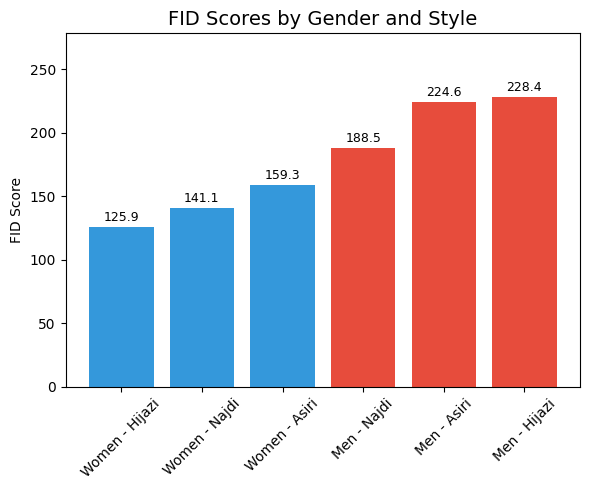


 FID bar plot saved to: eval-dataset/fid_bar_plot.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Path to the saved CSV
csv_path = "eval-dataset/fid_results.csv"

# Load the CSV into a DataFrame
df = pd.read_csv(csv_path)

# Combine gender and style for x-axis labels
df['Label'] = df['Gender'].str.capitalize() + " - " + df['Style'].str.capitalize()

# Sort if needed (optional)
df = df.sort_values(by="FID_Score", ascending=True)

# Plot setup
plt.figure(figsize=(6, 5))
colors = ['#E74C3C' if g == 'men' else '#3498DB' for g in df['Gender']]
bars = plt.bar(df['Label'], df['FID_Score'], color=colors)

# Title and axis labels
plt.title("FID Scores by Gender and Style", fontsize=14)
plt.ylabel("FID Score")
plt.xticks(rotation=45)
plt.ylim(0, max(df['FID_Score']) + 50)

# Add FID values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 2, f"{height:.1f}", ha='center', va='bottom', fontsize=9)

# Save the plot
plot_path = os.path.join("eval-dataset", "fid_bar_plot.png")
plt.tight_layout()
plt.savefig(plot_path)
plt.show()

print(f"\n FID bar plot saved to: {plot_path}")
